In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import itertools
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette("Blues", n_colors=21))
# Model: goal_4_score ~ year + GDP + population
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
# Load datasets
sdgsdf = pd.read_csv("sdg_index_2000-2022.csv")
df4 = pd.read_csv("4- mismanaged-plastic-waste-per-capita.csv")
gdp = pd.read_csv('filtered_dfgdp_2000_2020.csv')

In [3]:
# Data preprocessing
def preprocess_data(sdgsdf, df4, gdp):
    """Preprocess datasets and find common country codes"""
    # Filter years
    sdgs = sdgsdf[(sdgsdf['year'] >= 2000) & (sdgsdf['year'] <= 2020)].copy()
    
    # Get country codes (PROPERLY INDENTED INSIDE FUNCTION)
    sdgs_code = sdgs['country_code'].unique()
    df4_code = df4['Code'].unique()
    gdp_code = gdp['Code'].unique()
    
    # Find valid country codes present in all three datasets
    valid_codes = list(set(sdgs_code) & set(df4_code) & set(gdp_code))
    
    # Remove non-country codes (codes starting with '_')
    valid_codes = [code for code in valid_codes if not code.startswith('_')]
    
    return sdgs[sdgs['country_code'].isin(valid_codes)]

# Execute preprocessing
sdgs = preprocess_data(sdgsdf, df4, gdp)

In [4]:
# Define regional groupings
REGIONAL_GROUPS = {
    'Asia (Excl. China/India)': [
        'Bangladesh', 'Indonesia', 'Japan', 'Malaysia', 
        'Pakistan', 'Philippines', 'Thailand', 'Vietnam'
    ],
    'Europe': [
        'Germany', 'France', 'Italy', 'Spain', 'Sweden',
        'Netherlands', 'Switzerland', 'Norway', 'Denmark'
    ],
    'Americas (Excl. USA)': [
        'Brazil', 'Canada', 'Mexico', 'Argentina', 'Chile', 'Colombia'
    ],
    'Sub-Saharan Africa': [
        'Nigeria', 'South Africa', 'Kenya', 'Ghana', 'Ethiopia', 'Tanzania'
    ],
    'Middle East & North Africa': [
        'Egypt', 'Turkey', 'Iran', 'Saudi Arabia', 'Morocco', 'Algeria'
    ]
}


In [5]:
# Visualization functions
def create_timeseries_plot(df, region_name):
    """Create standardized time series plot with enhanced styling"""
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    ax = sns.lineplot(
        data=df, x="year", y="goal_4_score", hue="country",
        marker="o", markersize=8, linewidth=2.5, palette="tab10"
    )
    
    plt.title(f'SDG 4 - Quality Education Trends: {region_name} (2000-2020)',
              fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=14, labelpad=15)
    plt.ylabel('Education Quality Score', fontsize=14, labelpad=15)
    plt.xticks(range(2000, 2021, 2), rotation=45)
    
    # Move legend outside
    plt.legend(
        title='Country', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left',
        frameon=True,
        title_fontsize=12,
        fontsize=10
    )
    
    # Add grid customization
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(False)
    
    # Remove spines
    sns.despine(left=True)
    
    plt.tight_layout()
    return ax

def create_boxplot(df, region_name):
    """Create enhanced boxplot visualization"""
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    ax = sns.boxplot(
    x='year', 
    y='goal_4_score', 
    data=df,
    hue='year',  # Explicitly specify hue
    palette="Blues",
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
    legend=False  # Suppress redundant legend
)
    
    plt.title(f'Education Quality Distribution: {region_name} (2000-2020)',
              fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=14, labelpad=15)
    plt.ylabel('Education Quality Score', fontsize=14, labelpad=15)
    plt.xticks(rotation=45)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(False)
    
    sns.despine(left=True)
    plt.tight_layout()
    return ax

In [6]:
# Regional analysis pipeline
def analyze_region(region_name, countries):
    """Complete analysis pipeline for a region"""
    region_df = sdgs[sdgs['country'].isin(countries)].copy()
    
    # Ensure complete time series
    all_years = pd.DataFrame(
        itertools.product(countries, range(2000, 2021)),
        columns=['country', 'year']
    )
    region_df = pd.merge(all_years, region_df, on=['country', 'year'], how='left')

     # Clean missing values before analysis
    clean_df = region_df.dropna(subset=['goal_4_score']).copy()
    
    # Only calculate correlation if sufficient data exists
    if len(clean_df) >= 2:  # Minimum 2 data points for correlation
        # Visualization
        create_timeseries_plot(clean_df, region_name)
        create_boxplot(clean_df, region_name)
        
        # Statistical analysis
        stats = clean_df.groupby('country')['goal_4_score'].agg(['mean', 'median', 'std'])
        print(f"\n--- {region_name} Education Statistics ---")
        print(stats.round(2))
        
        # Temporal correlation analysis
        corr, p_value = pearsonr(clean_df['year'], clean_df['goal_4_score'])
        print(f"\nTemporal Correlation (Year vs Score):")
        print(f"Pearson r: {corr:.2f}, p-value: {p_value:.4f}")
    else:
        print(f"\n⚠️ Insufficient data for {region_name}: {len(clean_df)} valid records")
    
    return clean_df


--- Asia (Excl. China/India) Education Statistics ---
              mean  median    std
country                          
Bangladesh   53.48    53.0  10.20
Indonesia    87.58    88.7   4.42
Japan        95.20    95.6   0.64
Malaysia     88.47    88.9   1.34
Pakistan     54.03    54.5   4.52
Philippines  81.39    81.9   3.47
Thailand     92.31    91.4   2.27
Vietnam      90.29    89.7   6.06

Temporal Correlation (Year vs Score):
Pearson r: 0.19, p-value: 0.0113

--- Europe Education Statistics ---
              mean  median   std
country                         
Denmark      98.27    98.4  0.83
France       97.32    98.3  2.58
Germany      96.17    96.2  1.44
Italy        98.30    99.2  1.84
Netherlands  96.49    95.9  1.43
Norway       98.56    98.5  0.65
Spain        97.48    99.0  2.48
Sweden       97.31    97.1  1.88

Temporal Correlation (Year vs Score):
Pearson r: 0.13, p-value: 0.0837

--- Americas (Excl. USA) Education Statistics ---
            mean  median   std
country     

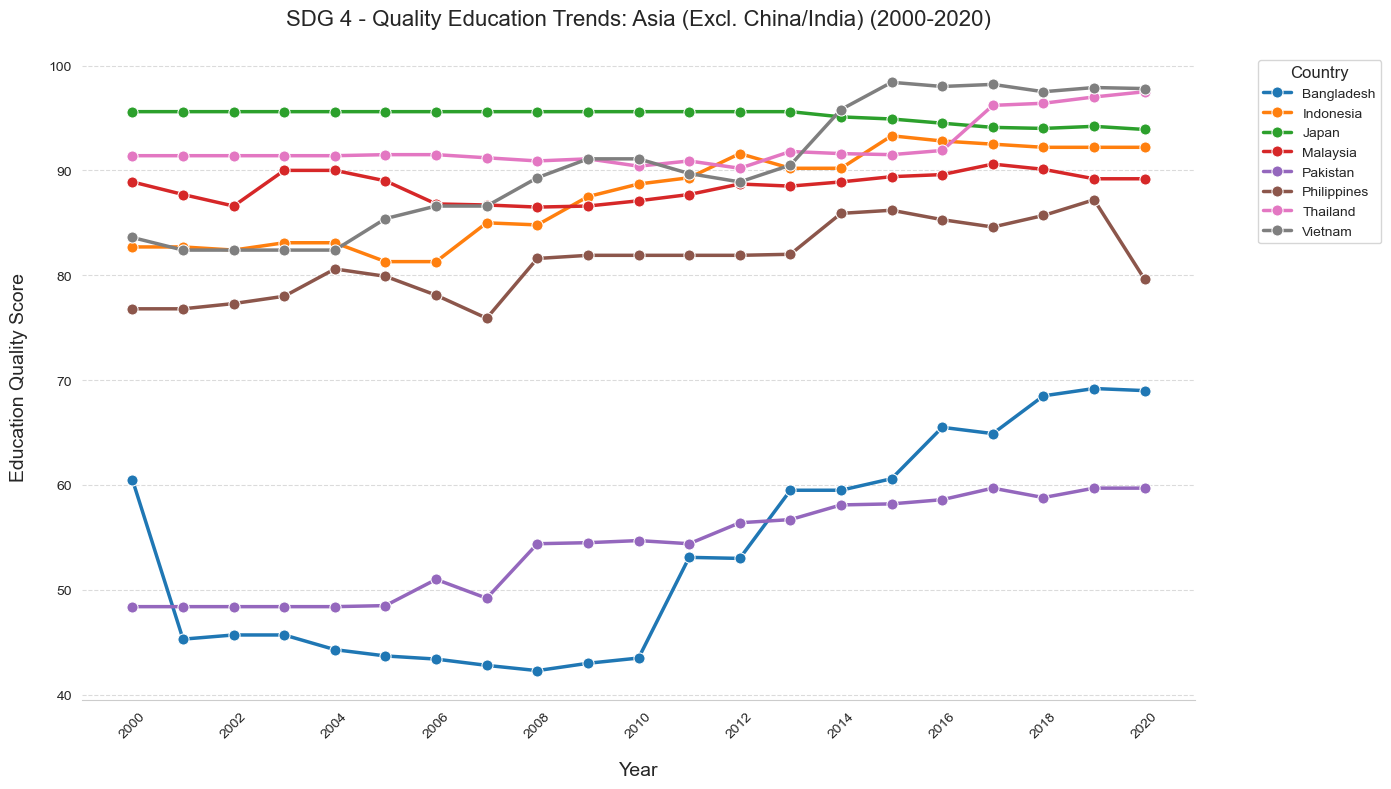

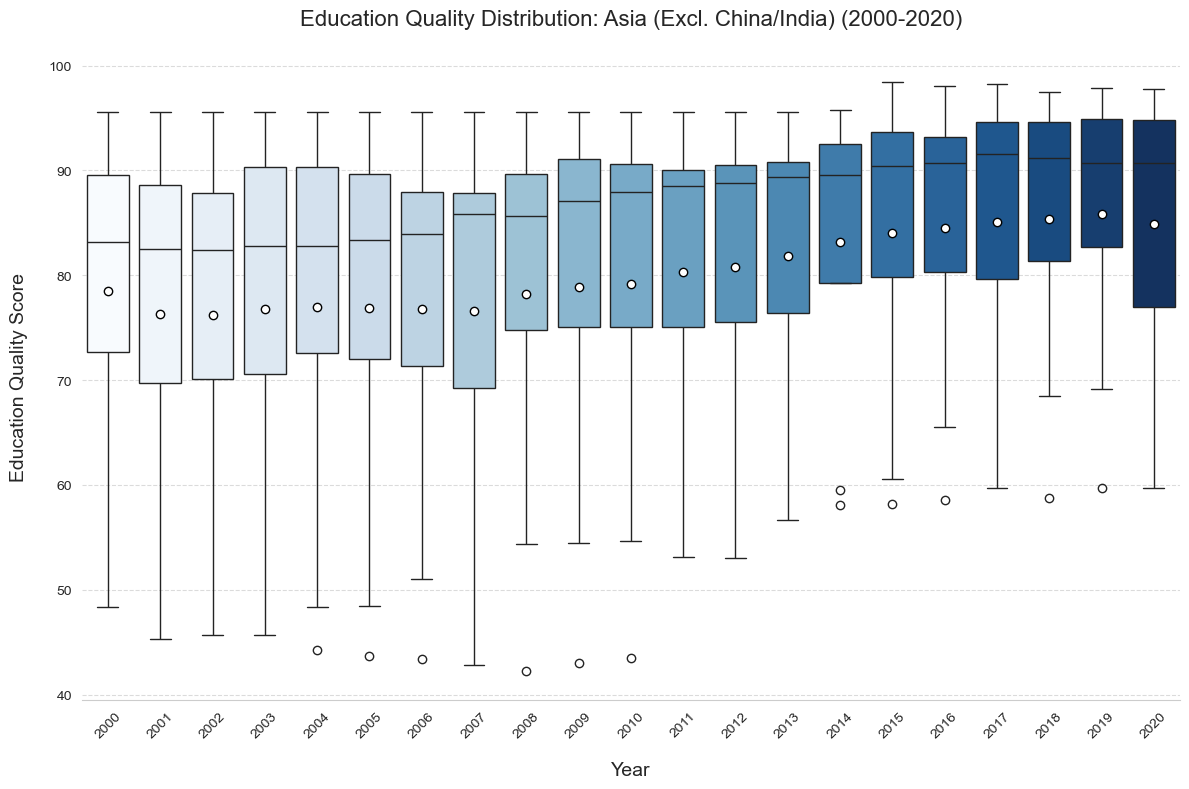

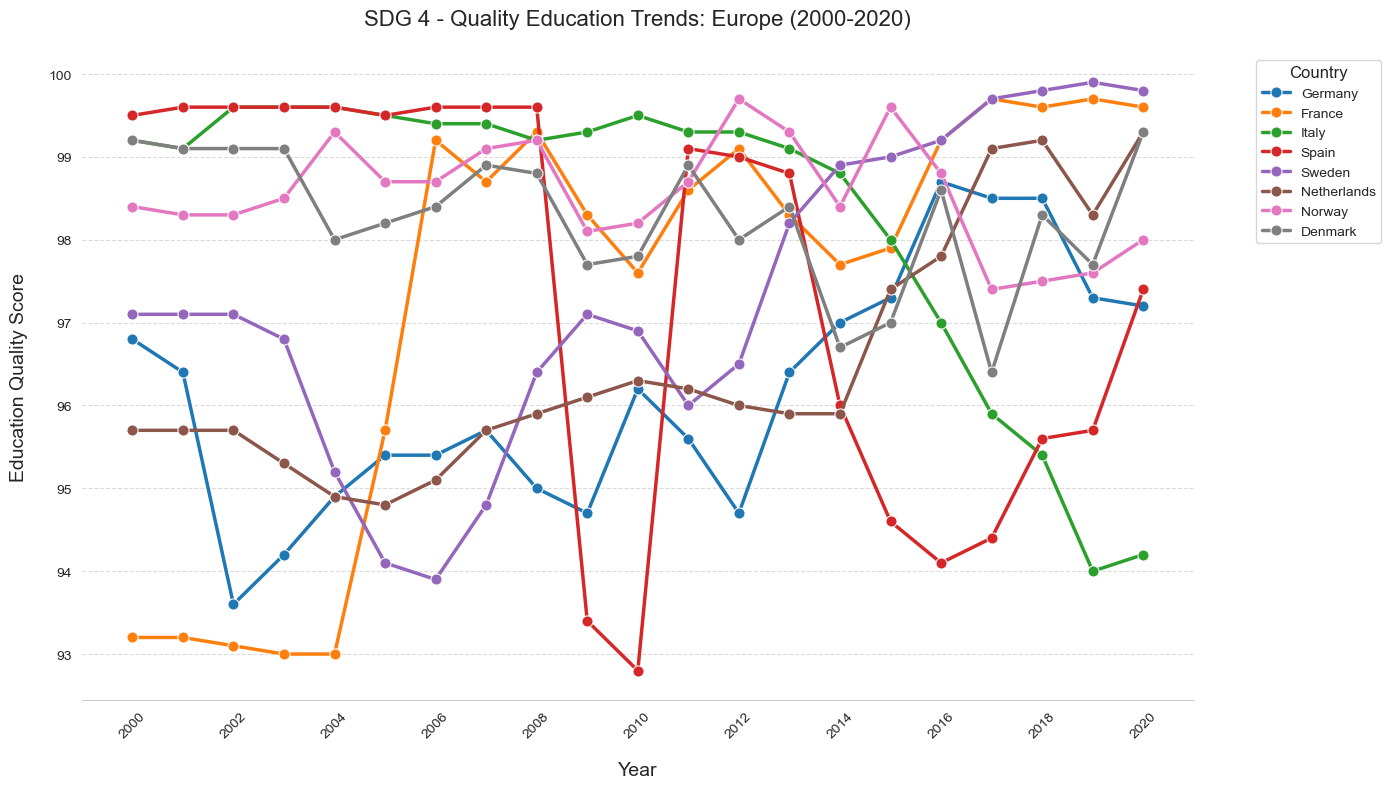

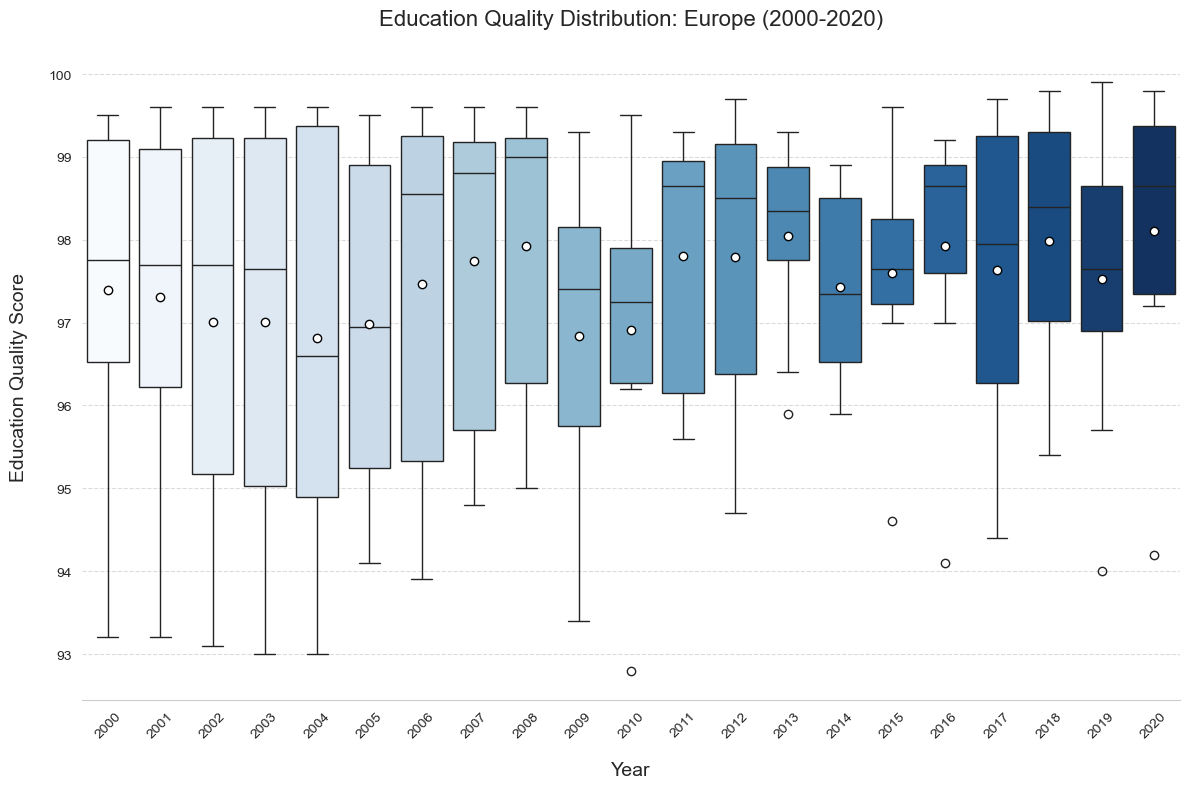

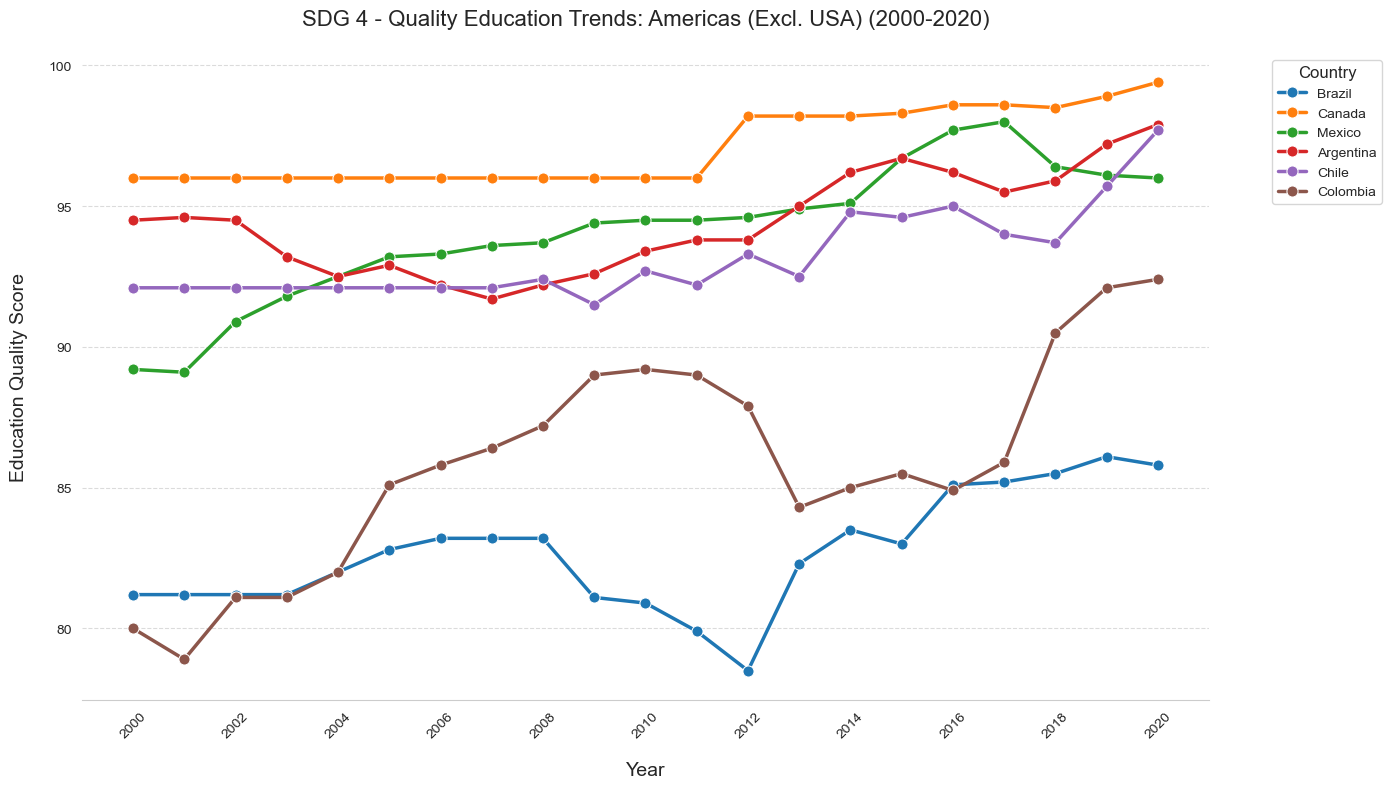

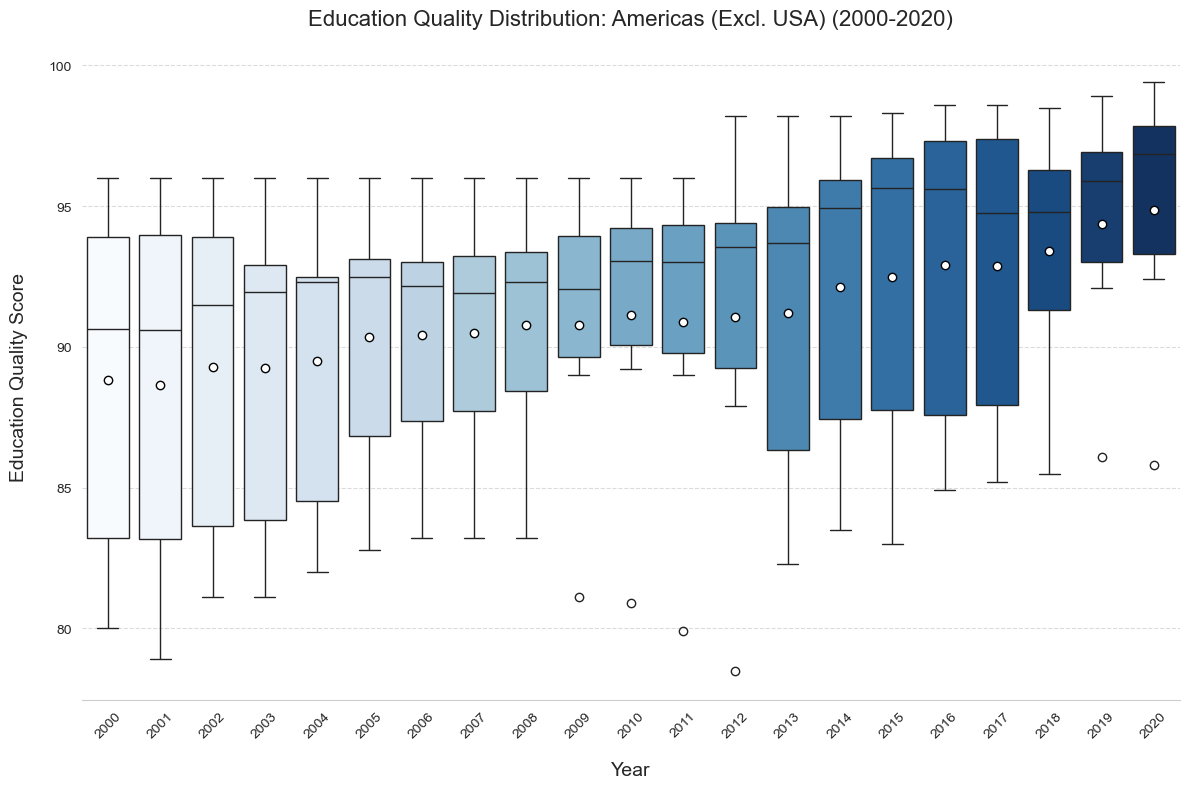

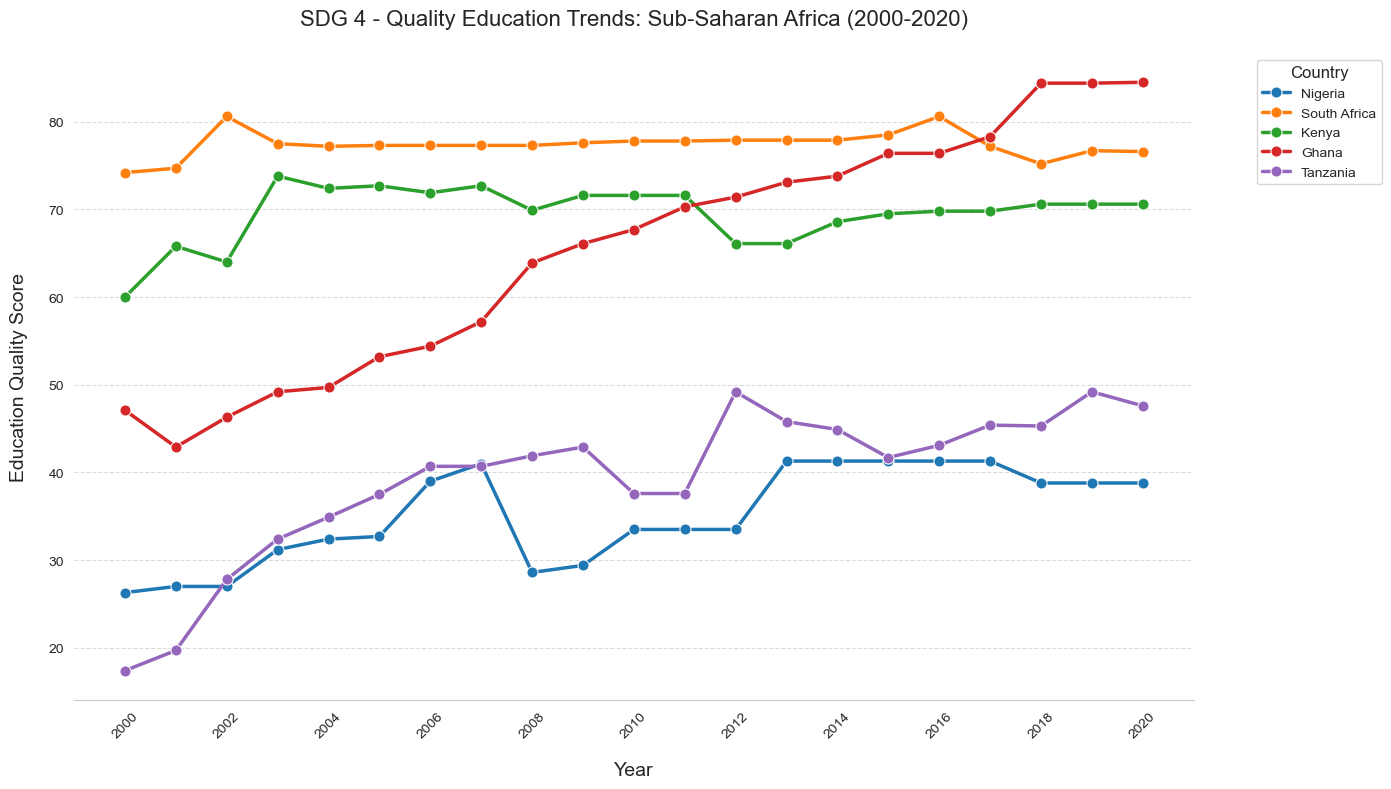

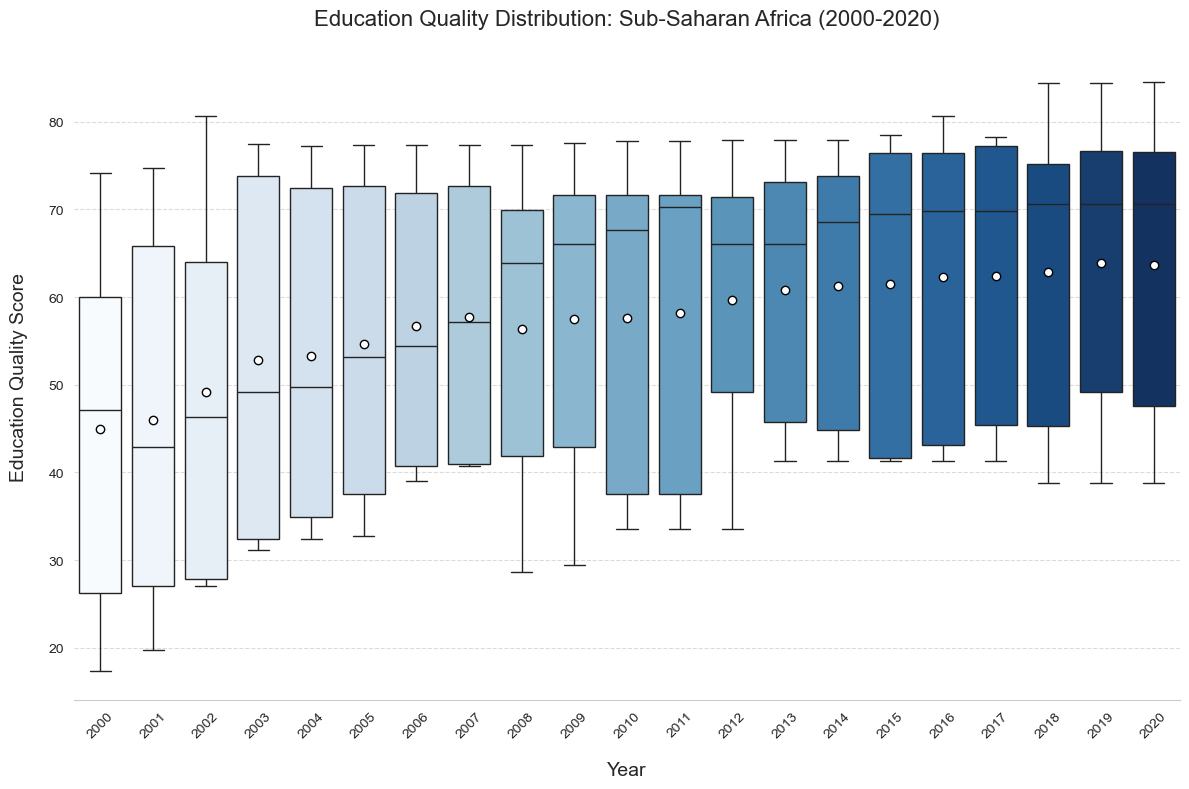

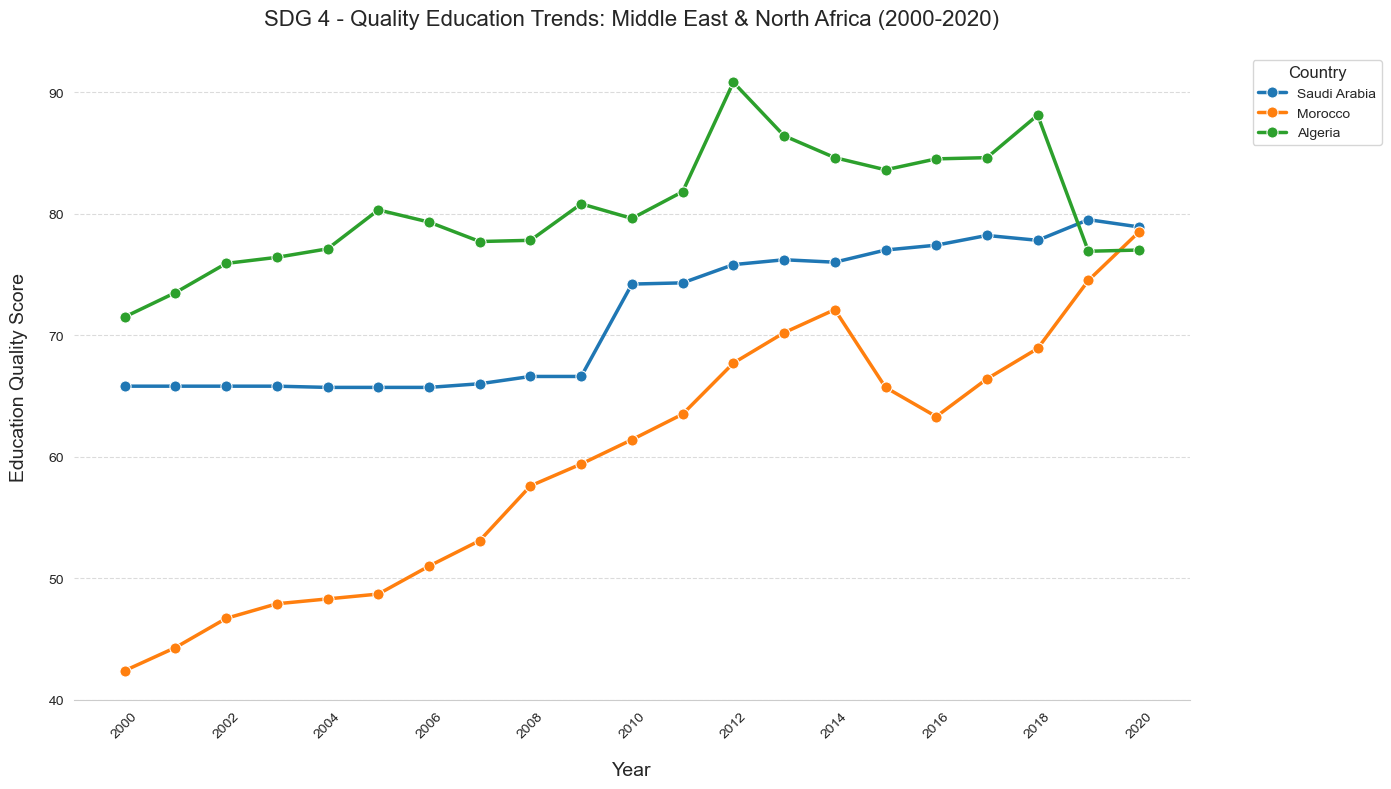

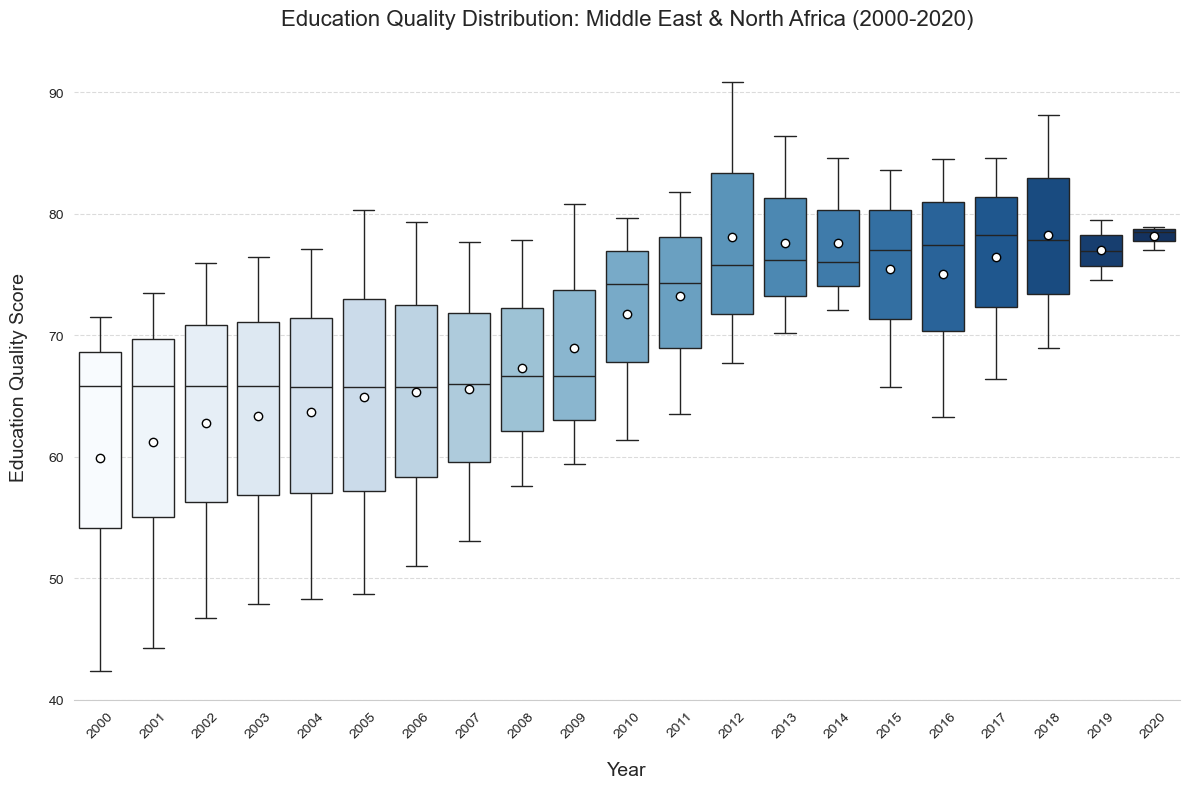

In [7]:
# Execute analysis for all regions
for region_name, countries in REGIONAL_GROUPS.items():
    _ = analyze_region(region_name, countries)


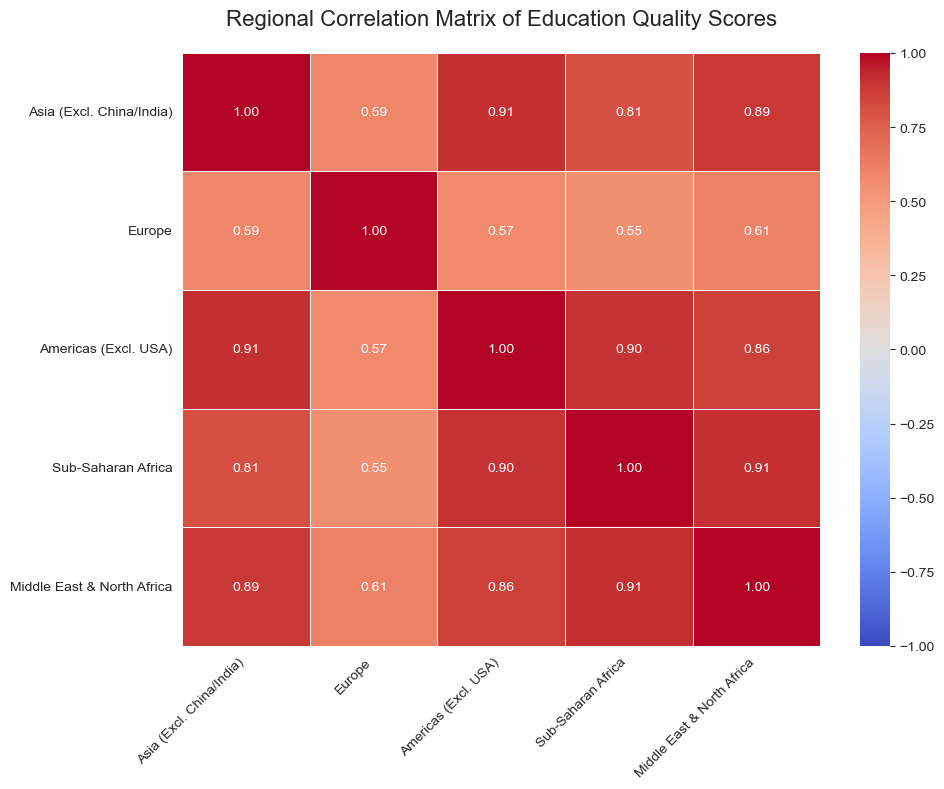

In [8]:
# Additional correlation analysis
def plot_correlation_heatmap():
    """Create regional correlation heatmap"""
    regional_means = []
    for region, countries in REGIONAL_GROUPS.items():
        region_mean = sdgs[sdgs['country'].isin(countries)].groupby('year')['goal_4_score'].mean()
        regional_means.append(region_mean.rename(region))
    
    corr_df = pd.concat(regional_means, axis=1).corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_df, 
        annot=True, 
        cmap="coolwarm", 
        vmin=-1, 
        vmax=1, 
        fmt=".2f", 
        linewidths=.5
    )
    plt.title('Regional Correlation Matrix of Education Quality Scores', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plot_correlation_heatmap()
plt.show()

    

In [9]:
# Save processed data
sdgs.to_csv('processed_sdg_data.csv', index=False)